In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
import warnings

In [9]:
warnings.filterwarnings("ignore")

## Przygotowanie danych do algorytmu SVM

Aby dane były odpowiednie do zastosowania w algorytmie SVM trzeba je przemapować -> dane słowne / cechy studentów trzeba przedstawić liczbowo. Użyłem do tego metody get_dummies() z bibliotek pandas aby podzielić kolumny na więcej wartości i przypisałem im 0 lub 1 w zależności czy dany student posiadał daną cechę. Np kolumna gender (male/female) została podzielona na dwie: gender_male oraz gender_female. Każdy student dostał 0 w gender_male oraz 1 w gender_female jeśli był kobietą. Na odwrót jeśli był mężczyzną. I tak dla każdej kolumny. 3 kolumny z wynikami można "zwinąć" do jednej kolumny o wartości 1 - student zdał lub -1 - student nie zdał. 

Następnie wykorzystalem metodę train_test_split() z biblioteki sklearn aby podzielić zbiór danych na treningowy i testowy. Metoda wybiera 80% losowych wierszy do zbioru treningowego oraz resztę do zbioru testowego. 

In [23]:
def initialize_dataset(input_file: str) -> tuple:

    dataframe = pd.read_csv(input_file)
    cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
    pre = ['gender', 'group', 'parent_ed', 'lunch', 'prep_course']
    dataframe  = pd.get_dummies(dataframe , columns=cols, prefix=pre, dtype=int)

    # Convert score columns to integers
    dataframe[['math score', 'reading score', 'writing score']] = dataframe[['math score', 'reading score', 'writing score']].astype(int)

    # Create a new column 'passed' based on your condition
    dataframe['passed'] = dataframe.apply(lambda row: 1 if (row['math score'] > 60) & (row['reading score'] > 60) & (row['writing score'] > 60) else -1, axis=1)
    dataframe.drop(['math score', 'reading score', 'writing score'], axis=1, inplace=True)

    x_train, x_test, y_train, y_test = tts(dataframe.drop(['passed'], axis=1), dataframe['passed'], test_size=0.2, random_state=42)

    return (x_train.to_numpy(), y_train.to_numpy(), x_test.to_numpy(), y_test.to_numpy())

In [11]:
class KernelNotSupported(Exception):
    def __init__(self, kernel):
        self.kernel = kernel
        self.message = "Kernel {} is not supported by this model, only linear and rbf are supported".format(self.kernel)

In [14]:
class MySVM:
    def __init__(self, C=1.0, kernel='rbf', gamma=0.1):
        self.C = C

        if kernel == 'linear':
            self.kernel = self._linear_kernel
        elif kernel == 'rbf':
            self.kernel = self._rbf_kernel
            self.gamma = gamma
        else:
            raise KernelNotSupported(kernel)

        self.X = None
        self.y = None
        self.alpha = None
        self.b = 0
        self.ones = None

    def _rbf_kernel(self, X1, X2):
        return np.exp(-self.gamma * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)

    def _linear_kernel(self, X1, X2):
        return X1.dot(X2.T)

    def fit(self, X, y, lr=1e-3, epochs=500, draw = False):

        self.X = X
        self.y = y

        # (500,)
        self.alpha = np.random.random(X.shape[0])
        self.b = 0
        # (500,)
        self.ones = np.ones(X.shape[0])

        # (500,500) =      (500,500) *        (500,500)
        y_iy_jk_ij = np.outer(y, y) * self.kernel(X, X)

        losses = []
        for _ in range(epochs):
            # (500,)  =    (500,)      (500,500).(500,)=(500,)
            gradient = self.ones - y_iy_jk_ij.dot(self.alpha)
            # Same code
            # gradient = self.ones - np.sum(y_iy_jk_ij * self.alpha)

            self.alpha = self.alpha + lr * gradient

            # prunning alfa values to [0, C]
            self.alpha[self.alpha > self.C] = self.C
            self.alpha[self.alpha < 0] = 0

            #                                        (500,500)                            (500,500)
            loss = np.sum(self.alpha) - 0.5 * np.sum(np.outer(self.alpha, self.alpha) * y_iy_jk_ij)
            losses.append(loss)

        index = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]
        # (m,)= (m,)       (n,).(n,m)= (m,)
        b_i = y[index] - (self.alpha * y).dot(self.kernel(X, X[index]))
        # Alternative code
        # b_i = y[index] - np.sum((self.alpha * y).reshape(-1, 1)*self.kernel(X, X[index]), axis=0)
        self.b = np.mean(b_i)
        if draw:
            plt.plot(losses)
            plt.title("loss per epochs")
            plt.show()

    def _decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b

    def predict(self, X):
        return np.sign(self._decision_function(X))

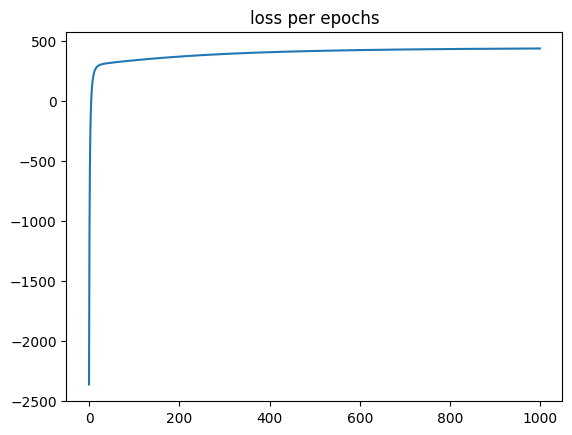

My linear accuracy: 0.69
My linear precision: 0.7109375
My linear recall: 0.7844827586206896
My linear confusion Matrix:
 [[47 37]
 [25 91]]
Lib linear accuracy: 0.69
Lib linear precision: 0.6956521739130435
Lib linear recall: 0.8275862068965517
Lib linear confusion Matrix:
 [[42 42]
 [20 96]]


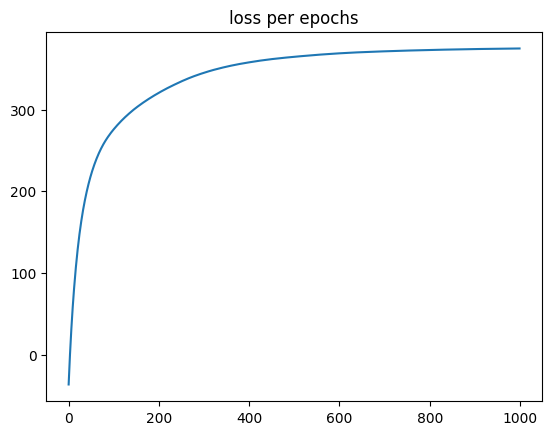

My rbf accuracy: 0.645
My rbf precision: 0.6923076923076923
My rbf recall: 0.6982758620689655
My rbf confusion Matrix:
 [[48 36]
 [35 81]]
Lib rbf accuracy: 0.635
Lib rbf precision: 0.6747967479674797
Lib rbf recall: 0.7155172413793104
Lib rbf confusion Matrix:
 [[44 40]
 [33 83]]


In [15]:
x_train, y_train, x_test, y_test = initialize_dataset("dataset.csv")

svm = MySVM(C=0.8, kernel='linear')
svm.fit(x_train, y_train, lr=1e-3, epochs=1000, draw=True)
prediction = svm.predict(x_test)

print("My linear accuracy:", accuracy_score(prediction, y_test))
print("My linear precision:", precision_score(y_test, prediction))
print("My linear recall:", recall_score(y_test, prediction))
print("My linear confusion Matrix:\n", confusion_matrix(y_test, prediction))

lib_svm = SVC(C=0.8, kernel='linear', max_iter=1000)
lib_svm.fit(x_train, y_train)
prediction = lib_svm.predict(x_test)

print("Lib linear accuracy:", accuracy_score(prediction, y_test))
print("Lib linear precision:", precision_score(y_test, prediction))
print("Lib linear recall:", recall_score(y_test, prediction))
print("Lib linear confusion Matrix:\n", confusion_matrix(y_test, prediction))

svm = MySVM(C=0.8, kernel='rbf', gamma=0.7)
svm.fit(x_train, y_train, lr=1e-3, epochs=1000, draw=True)
prediction = svm.predict(x_test)

print("My rbf accuracy:", accuracy_score(prediction, y_test))
print("My rbf precision:", precision_score(y_test, prediction))
print("My rbf recall:", recall_score(y_test, prediction))
print("My rbf confusion Matrix:\n", confusion_matrix(y_test, prediction))

lib_svm = SVC(C=0.8, kernel='rbf', gamma=.7, max_iter=1000)
lib_svm.fit(x_train, y_train)
prediction = lib_svm.predict(x_test)

print("Lib rbf accuracy:", accuracy_score(prediction, y_test))
print("Lib rbf precision:", precision_score(y_test, prediction))
print("Lib rbf recall:", recall_score(y_test, prediction))
print("Lib rbf confusion Matrix:\n", confusion_matrix(y_test, prediction))

In [16]:
def draw_graphs():
    c = np.linspace(0.01, 5, 50)
    input_file = "dataset.csv"
    x_train, y_train, x_test, y_test = initialize_dataset(input_file)

    fig, axs = plt.subplots(3, 1, figsize=(8, 12))

    kernels = ['linear', 'rbf']
    metrics = ['Accuracy', 'Precision', 'Recall']

    for kernel in kernels:
        my_acc = []
        my_prec = []
        my_rec = []
        lib_acc = []
        lib_prec = []
        lib_rec = []

        for i in c:
            my_svm = MySVM(kernel=kernel, C=i, gamma=0.7)
            my_svm.fit(x_train, y_train, epochs=1000)
            prediction = my_svm.predict(x_test)

            my_acc.append(accuracy_score(prediction, y_test))
            my_prec.append(precision_score(prediction, y_test))
            my_rec.append(recall_score(prediction, y_test))

            lib_svc = SVC(kernel=kernel, C=i, gamma=0.7, max_iter=1000)
            lib_svc.fit(x_train, y_train)
            prediction = lib_svc.predict(x_test)

            lib_acc.append(accuracy_score(prediction, y_test))
            lib_prec.append(precision_score(prediction, y_test))
            lib_rec.append(recall_score(prediction, y_test))

        # Plot accuracy
        axs[0].plot(c, my_acc, label=f'My {kernel} accuracy')
        axs[0].plot(c, lib_acc, label=f'Lib {kernel} accuracy')

        # Plot precision
        axs[1].plot(c, my_prec, label=f'My {kernel} precision')
        axs[1].plot(c, lib_prec, label=f'Lib {kernel} precision')

        # Plot recall
        axs[2].plot(c, my_rec, label=f'My {kernel} recall')
        axs[2].plot(c, lib_rec, label=f'Lib {kernel} recall')

    for ax, metric in zip(axs, metrics):
        ax.set_xlabel('C')
        ax.set_ylabel(metric)
        ax.legend()

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plots
    plt.show()


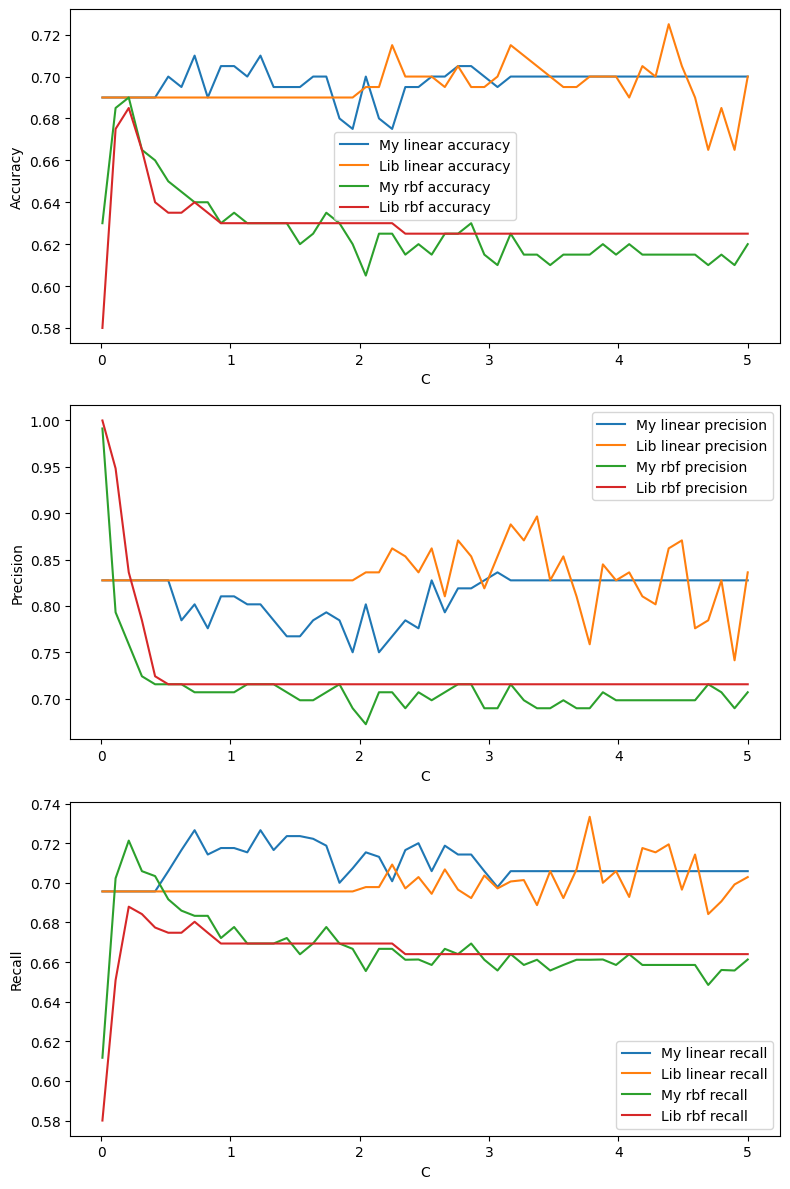

In [17]:
draw_graphs()